(Copied from argmax)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from pynq import allocate

In [2]:
from pynq import PL
PL.reset()
import xrfdc

In [3]:
from pynq import Overlay
ol = Overlay('./tracker.bit')

In [4]:
# sanity check that we are at 150 MHz
from pynq import Clocks
print(Clocks.fclk0_mhz)
Clocks.fclk0_mhz = 150
print(Clocks.fclk0_mhz)

214.283571
149.9985


In [5]:
rf = ol.usp_rf_data_converter_0
adc_tile = rf.adc_tiles[2]
adc_block = adc_tile.blocks[0]
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
center_frequency = 1575.43
doppler = 0
adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(adc_block.MixerSettings)

{'Freq': 1575.429999999993, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}


In [6]:
N = 4096
num_width = 32

In [7]:
mmio_interface = ol.mmio_interface
dma_argmax = ol.axi_dma_0
dma_prn_config = ol.axi_prn_config
dma_iq_config = ol.axi_iq_config
dma_ifft_config = ol.axi_ifft_config

In [8]:
# set up ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0
ifft_config = allocate(1, dtype=np.uint8)
ifft_config[0] = 1
# note they are default inverse (1)
dma_prn_config.sendchannel.transfer(fft_config)
dma_prn_config.sendchannel.wait()
dma_iq_config.sendchannel.transfer(fft_config)
dma_iq_config.sendchannel.wait()
dma_ifft_config.sendchannel.transfer(ifft_config)
dma_ifft_config.sendchannel.wait()

In [9]:
# get ready to read argmax data
argmax_data = allocate(2, dtype=np.uint32)
mmio_interface.write(0x08, 1)

In [10]:
# numerical helpers
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos
    
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [17]:
def get_component(x, num_bits):
    return {
        'real': get_decimal_from_twos(x // (1<<num_bits), num_bits),
        'imag': get_decimal_from_twos(x % (1<<num_bits), num_bits)
    }

In [18]:
def get_argmax_data(): #outputs 1 code block
    dma_argmax.recvchannel.transfer(argmax_data)
    dma_argmax.recvchannel.wait()

In [32]:
def process_data():
    value = argmax_data[1]
    index = argmax_data[0]
    complex_value = get_component(value, 16)['real'] + get_component(value, 16)['imag']
    # amplitude, index
    return complex_value, index

In [13]:
get_argmax_data()

In [14]:
def set_freq(doppler_choice):
    adc_block.MixerSettings['Freq'] = center_frequency + doppler_choice / 1e6 # set the frequency of the Numerically controlled oscillator.
    adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.

In [21]:
def doppler_sweep(prn_id, start = -8000, end = 8000, step = 100, scaling = 16): #sweeps frequency range
    doppler_range = list(range(start, end, step))
    mmio_interface.write(0x00, scaling)
    mmio_interface.write(0x04, prn_id-1)

    data = []
    amplitudes = []
    for doppler in doppler_range:
        set_freq(center_frequency + doppler / 1e6)
        get_argmax_data()
        amplitudes.append(abs(complex_value))
    return data, amplitudes

In [25]:
prn_id = 30

In [26]:
data, amplitudes = doppler_sweep(prn_id)
data

[{'complex_value': 5340, 'index': 2286, 'doppler': -8000},
 {'complex_value': -7377, 'index': 998, 'doppler': -7900},
 {'complex_value': 4533, 'index': 978, 'doppler': -7800},
 {'complex_value': -7960, 'index': 1140, 'doppler': -7700},
 {'complex_value': 6559, 'index': 1659, 'doppler': -7600},
 {'complex_value': -6918, 'index': 52, 'doppler': -7500},
 {'complex_value': -5720, 'index': 2711, 'doppler': -7400},
 {'complex_value': 6838, 'index': 2589, 'doppler': -7300},
 {'complex_value': -6168, 'index': 3514, 'doppler': -7200},
 {'complex_value': 4947, 'index': 3960, 'doppler': -7100},
 {'complex_value': -7340, 'index': 746, 'doppler': -7000},
 {'complex_value': -7696, 'index': 263, 'doppler': -6900},
 {'complex_value': 7008, 'index': 1263, 'doppler': -6800},
 {'complex_value': -7013, 'index': 1521, 'doppler': -6700},
 {'complex_value': 6913, 'index': 3316, 'doppler': -6600},
 {'complex_value': -4557, 'index': 1795, 'doppler': -6500},
 {'complex_value': 6304, 'index': 2874, 'doppler': -6

In [27]:
# for now, let's just track the satellite with maximum amplitude
best_doppler_index = np.argmax(np.array(amplitudes))
best_doppler = data[best_doppler_index]['doppler']
print(f'prn: {prn_id}, doppler: {best_doppler}')

prn: 30, doppler: -900


In [28]:
# now we track by doing the 1000 but mod 3
# if 0 mod 3 go at cur doppler
# if 1 mod 3 add 5 to doppler
# if 2 mod 3 minus 5 to doppler
# then set doppler to the highest of the both between them

In [37]:
import time
start_time = time.time()

best_amplitude = np.array([0, 0, 0])
dopplers = []

mmio_interface.write(0x04, int(prn_id)-1)

# try tracking over multiple seconds

for i in range(1000):
    if i//10 % 3 == 0:
        set_freq(doppler)
        best_index = np.argmax(best_amplitude)
        if best_index == 1:
            doppler += 5
        elif best_index == 2:
            doppler -= 5
    elif i//10 % 3 == 1:
        set_freq(doppler - 5)
    else:
        set_freq(doppler + 5)
    get_argmax_data()
    value = argmax_data[1]
    index = argmax_data[0]
    complex_value = get_component(value, 16)['real'] + get_component(value, 16)['imag']
    best_amplitude[i%3] = abs(complex_value)
    print(f"got sample {i}, time since start {time.time()-start_time}")
    dopplers.append(doppler)

got sample 0, time since start 0.03340005874633789
got sample 1, time since start 0.06110978126525879
got sample 2, time since start 0.08881545066833496
got sample 3, time since start 0.11807584762573242
got sample 4, time since start 0.1458745002746582
got sample 5, time since start 0.17365169525146484
got sample 6, time since start 0.20144438743591309
got sample 7, time since start 0.2292468547821045
got sample 8, time since start 0.2570688724517822
got sample 9, time since start 0.28504061698913574
got sample 10, time since start 0.3127598762512207
got sample 11, time since start 0.3414733409881592
got sample 12, time since start 0.36946725845336914
got sample 13, time since start 0.3971443176269531
got sample 14, time since start 0.4248638153076172
got sample 15, time since start 0.452664852142334
got sample 16, time since start 0.48056578636169434
got sample 17, time since start 0.5083248615264893
got sample 18, time since start 0.5361330509185791
got sample 19, time since start 0

got sample 161, time since start 4.5322558879852295
got sample 162, time since start 4.559954643249512
got sample 163, time since start 4.58771014213562
got sample 164, time since start 4.615419149398804
got sample 165, time since start 4.643062353134155
got sample 166, time since start 4.670751571655273
got sample 167, time since start 4.6987597942352295
got sample 168, time since start 4.727766990661621
got sample 169, time since start 4.75546407699585
got sample 170, time since start 4.783218860626221
got sample 171, time since start 4.810888051986694
got sample 172, time since start 4.83856201171875
got sample 173, time since start 4.866598844528198
got sample 174, time since start 4.894265413284302
got sample 175, time since start 4.921867370605469
got sample 176, time since start 4.949498653411865
got sample 177, time since start 4.9784462451934814
got sample 178, time since start 5.006191253662109
got sample 179, time since start 5.033853769302368
got sample 180, time since star

got sample 322, time since start 9.016417741775513
got sample 323, time since start 9.044142723083496
got sample 324, time since start 9.072996854782104
got sample 325, time since start 9.100619554519653
got sample 326, time since start 9.128268957138062
got sample 327, time since start 9.155997037887573
got sample 328, time since start 9.183664083480835
got sample 329, time since start 9.211403131484985
got sample 330, time since start 9.239102125167847
got sample 331, time since start 9.266857624053955
got sample 332, time since start 9.294620513916016
got sample 333, time since start 9.323642015457153
got sample 334, time since start 9.35153579711914
got sample 335, time since start 9.379289865493774
got sample 336, time since start 9.407052516937256
got sample 337, time since start 9.43479299545288
got sample 338, time since start 9.462648391723633
got sample 339, time since start 9.490481853485107
got sample 340, time since start 9.518333673477173
got sample 341, time since start 

got sample 481, time since start 13.443408012390137
got sample 482, time since start 13.471170663833618
got sample 483, time since start 13.498923540115356
got sample 484, time since start 13.526570558547974
got sample 485, time since start 13.554454565048218
got sample 486, time since start 13.58215856552124
got sample 487, time since start 13.609879493713379
got sample 488, time since start 13.63763689994812
got sample 489, time since start 13.666509866714478
got sample 490, time since start 13.694176197052002
got sample 491, time since start 13.722036838531494
got sample 492, time since start 13.749622821807861
got sample 493, time since start 13.77726697921753
got sample 494, time since start 13.804876804351807
got sample 495, time since start 13.832438230514526
got sample 496, time since start 13.860308408737183
got sample 497, time since start 13.887887954711914
got sample 498, time since start 13.916853189468384
got sample 499, time since start 13.944364309310913
got sample 500,

got sample 640, time since start 17.870588302612305
got sample 641, time since start 17.89827847480774
got sample 642, time since start 17.925859928131104
got sample 643, time since start 17.953524827957153
got sample 644, time since start 17.981173276901245
got sample 645, time since start 18.008866548538208
got sample 646, time since start 18.037651538848877
got sample 647, time since start 18.065327167510986
got sample 648, time since start 18.092936277389526
got sample 649, time since start 18.120508670806885
got sample 650, time since start 18.148199319839478
got sample 651, time since start 18.17586612701416
got sample 652, time since start 18.203539848327637
got sample 653, time since start 18.231218099594116
got sample 654, time since start 18.259949207305908
got sample 655, time since start 18.287959575653076
got sample 656, time since start 18.315687656402588
got sample 657, time since start 18.343357801437378
got sample 658, time since start 18.371052265167236
got sample 659

got sample 799, time since start 22.298684120178223
got sample 800, time since start 22.326342582702637
got sample 801, time since start 22.353989839553833
got sample 802, time since start 22.382813930511475
got sample 803, time since start 22.410572052001953
got sample 804, time since start 22.438059329986572
got sample 805, time since start 22.465810298919678
got sample 806, time since start 22.4934663772583
got sample 807, time since start 22.52107548713684
got sample 808, time since start 22.54875898361206
got sample 809, time since start 22.5763943195343
got sample 810, time since start 22.60431694984436
got sample 811, time since start 22.633124351501465
got sample 812, time since start 22.6608829498291
got sample 813, time since start 22.68860149383545
got sample 814, time since start 22.716429471969604
got sample 815, time since start 22.744173288345337
got sample 816, time since start 22.77208971977234
got sample 817, time since start 22.799930334091187
got sample 818, time si

got sample 958, time since start 26.72841763496399
got sample 959, time since start 26.755958795547485
got sample 960, time since start 26.783681392669678
got sample 961, time since start 26.811412811279297
got sample 962, time since start 26.83915424346924
got sample 963, time since start 26.866882801055908
got sample 964, time since start 26.894583225250244
got sample 965, time since start 26.92231512069702
got sample 966, time since start 26.949953317642212
got sample 967, time since start 26.97888684272766
got sample 968, time since start 27.006598949432373
got sample 969, time since start 27.034311532974243
got sample 970, time since start 27.061938524246216
got sample 971, time since start 27.089491367340088
got sample 972, time since start 27.117050886154175
got sample 973, time since start 27.14472985267639
got sample 974, time since start 27.172481775283813
got sample 975, time since start 27.201278686523438
got sample 976, time since start 27.22891354560852
got sample 977, ti

In [ ]:
plt.plot(list(range(1000)), dopplers)

In [18]:
indices = argmax_data[0::2]
values = argmax_data[1::2]
real = get_components(values,16)["real"]
imag = get_components(values,16)["imag"]
mag = [abs(real[i]+imag[i]*1j) for i in range(1000)]


In [19]:
sum(mag)

5292366.45587172

(array([ 78., 165., 131.,  64.,  43.,  36.,  70., 122., 196.,  95.]),
 array([-6025., -4820., -3615., -2410., -1205.,     0.,  1205.,  2410.,
         3615.,  4820.,  6025.]),
 <BarContainer object of 10 artists>)

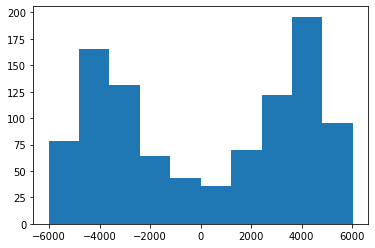

In [20]:
plt.hist(imag)

(array([139., 153., 114.,  58.,  33.,  41.,  97., 156., 173.,  36.]),
 array([-5781. , -4557.9, -3334.8, -2111.7,  -888.6,   334.5,  1557.6,
         2780.7,  4003.8,  5226.9,  6450. ]),
 <BarContainer object of 10 artists>)

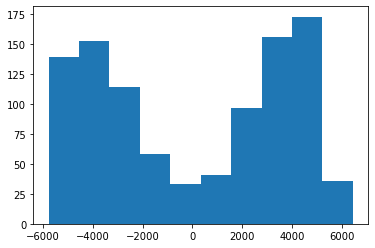

In [21]:
plt.hist(real)

(array([  1.,   0.,   0.,   0.,   0.,   0., 606., 373.,  19.,   1.]),
 array([   0.        ,  761.96908074, 1523.93816148, 2285.90724221,
        3047.87632295, 3809.84540369, 4571.81448443, 5333.78356516,
        6095.7526459 , 6857.72172664, 7619.69080738]),
 <BarContainer object of 10 artists>)

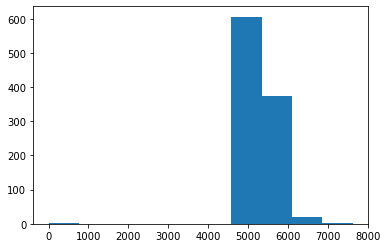

In [22]:
plt.hist(mag)

(array([119.,  97.,  91., 108.,  80., 111.,  94., 101., 102.,  97.]),
 PynqBuffer([   0. ,  408.5,  817. , 1225.5, 1634. , 2042.5, 2451. ,
             2859.5, 3268. , 3676.5, 4085. ]),
 <BarContainer object of 10 artists>)

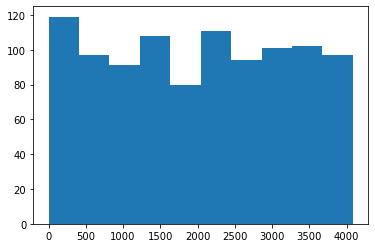

In [23]:
plt.hist(indices)

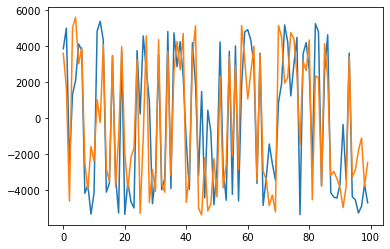

In [24]:
plt.plot(list(range(0,100)), imag[:100])
plt.plot(list(range(0,100)), real[:100])

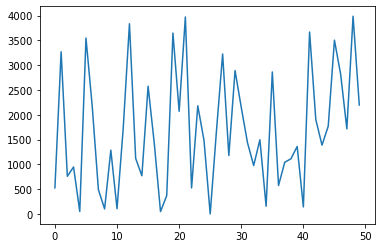

In [25]:
plt.plot(list(range(0,50)), indices[200:250])

In [26]:
for shift in range(-750,-550,10):
    print(shift, test_shift(shift, 27))

-750 5316753.304434993
-740 5322833.639517059
-730 5297780.012546539
-720 5297376.627737484
-710 5300472.981779708
-700 5300388.614662894
-690 5305745.528922505
-680 5302682.02751089
-670 5299869.735898838
-660 5301793.105660801
-650 5313839.50539826
-640 5308446.033239497
-630 5311392.859487586
-620 5300220.106002171
-610 5319587.222455496
-600 5318584.701014409
-590 5280758.756050931
-580 5311487.563689083
-570 5300899.763455489
-560 5316648.378465036


In [27]:
real, imag, indices = collect(-1680,27)
phase_shift = np.array([np.angle(real[i]+imag[i]*1j) for i in range(1000)])

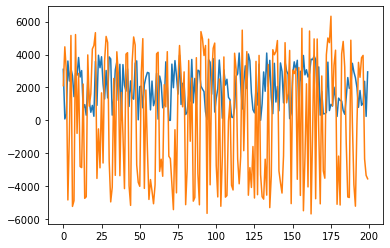

In [28]:
base_index = 400
number = 200
plt.plot(list(range(0,number)), indices[base_index:base_index+number])
plt.plot(list(range(0,number)), real[base_index:base_index+number])

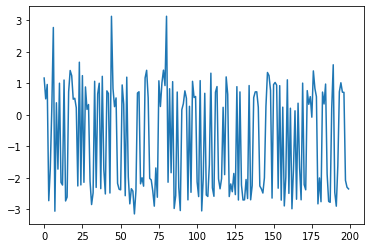

In [29]:
plt.plot(list(range(0,number)), phase_shift[base_index:base_index+number])

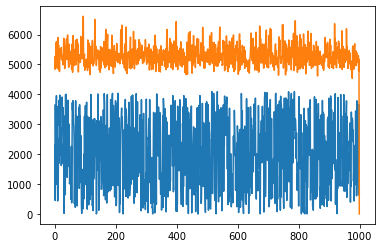

In [30]:
plt.plot(list(range(0,1000)), indices)
plt.plot(list(range(0,1000)), mag)

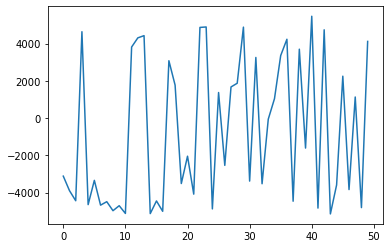

In [31]:
plt.plot(list(range(0,50)), real[200:250])

In [32]:
import statistics
def bpsk_filter(phase_shift, indices, downsample = 5):
    #only take data that is close to the index
    #we down sample by 5? for now
    filtered = []
    for i in range(0,1000,downsample):
        subphase = list(phase_shift[i:min(1000,i+downsample)])
        subindices = list(indices[i:min(1000,i+downsample)])
        indexmode = statistics.mode(subindices)
        location = subindices.index(indexmode)
        chosenphase = subphase[location]
        filtered.append(chosenphase)
        print(i,indexmode,chosenphase)
    return(filtered)
    
filtered = bpsk_filter(phase_shift, indices)

0 3637 -2.6863411529154178
5 3957 0.7678750178370598
10 574 1.329325102623318
15 2948 -2.3928687883783857
20 2875 -2.537279877670467
25 3031 0.4862961244451111
30 19 -1.9733853107633732
35 3998 -3.1306252272712802
40 1225 0.7072942043745652
45 2911 -2.2025591632998056
50 1203 0.09799378752318585
55 369 0.9186952043202824
60 3501 0.830293978771464
65 1090 0.6822699717471906
70 2893 -1.9259097742540712
75 2813 -2.267369601686092
80 852 -2.7388774807827847
85 2622 -2.667431519167181
90 1460 0.8823623098099601
95 1997 -2.210489723888998
100 3623 1.3073663731413534
105 936 -2.447042656986064
110 1197 -2.3340495854271017
115 479 0.48699865515554275
120 3130 0.7097787141554098
125 110 0.5793476566935495
130 3194 1.057292771028731
135 1537 1.1472405205179852
140 1475 0.2728421857585533
145 2836 -1.8457980302251724
150 1953 -2.0748029908830956
155 1216 -2.600788820156203
160 610 0.5856138663347638
165 985 0.9869075156048105
170 364 -2.27298814565912
175 897 0.818061008372081
180 1589 -3.0176789

In [35]:
# convolve at current doppler
# convolve with doppler before and doppler after (5Hz)
# adjust in the correct dir
# output the correct convolution
# graph the doppler over time

In [33]:
#testing how fast the code delay shifts
#print(statistics.mode(indices[0:10]))
#print(statistics.mode(indices[10:20]))
#print(statistics.mode(indices[90:95]))
#print(statistics.mode(indices[910:915]))

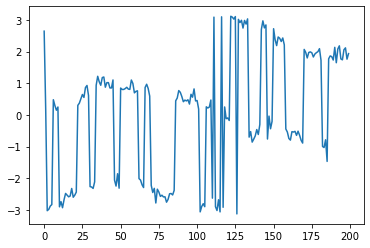

In [486]:
plt.plot(list(range(0,200)), filtered)
plt.savefig('bpsk-2.png')

In [494]:
with open("filtered-data", "w") as z:
    for i in filtered:
        z.write(str(i))
        z.write("\n")

In [485]:
np.pi % (2* np.pi)

3.141592653589793